In [1]:
import numpy as np
import pandas as pd
import comonotonic as cm
import naiveBayes as nb
import os
from sklearn.model_selection import train_test_split
import copy
import utils
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Note that we assume the last column is the label
# If the first column is ID's, remove it
filename = "adult.csv"
random_state = 24
df = pd.read_csv("Datasets/"+filename)
# education and education.num is actually the same, so drop "education"
colnames = [('X'+str(i)) for i in range(df.shape[1]-1)]
colnames.append('Y')
df.columns = colnames

In [3]:
colname_dict = {'X0':"age", 'X1': 'workclass', 'X2': 'fnlwgt', 'X3': 'education', 'X4': 'education.num', 'X5': 'marital.status',
                'X6': 'occupation', 'X7': 'relationship', 'X8': 'race', 'X9': 'sex', 'X10': 'capital.gain', 'X11': 'capital.loss', 
                'X12': 'hours.per.week', 'X13': 'native.country', 'Y': 'income'}

In [4]:
#data cleaning for adult.csv
df = df[df.X1 != '?']
df = df[df.X6 != '?']
# unrankable features
encoded_df = utils.encode_df(df, [1,5,6,7,8,9,13])


encoded_df.loc[(encoded_df.Y == "<=50K"),'Y'] = 0
encoded_df.loc[(encoded_df.Y == ">50K"),'Y'] = 1

encoded_df.loc[(encoded_df.X4 <= 9),'X3'] = 0
encoded_df.loc[(encoded_df.X4 == 10),'X3'] = 1
encoded_df.loc[(encoded_df.X4 == 11),'X3'] = 2
encoded_df.loc[(encoded_df.X4 == 12),'X3'] = 2
encoded_df.loc[(encoded_df.X4 >= 13),'X3'] = 3

encoded_df = encoded_df.astype('int32')

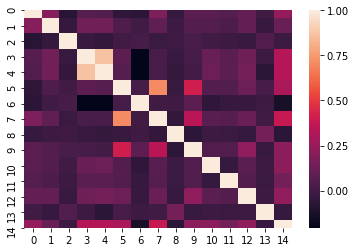

In [7]:
corr = np.corrcoef(encoded_df.to_numpy().T)
sns.heatmap(corr)

In [5]:
# continuous variables; categorical rankable features are [3]
cont_col = [0,2,4,10,11,12]
# unrankable columns
unrankable = [1,5,6,7,8,9,13]
discrete_col = [1,3,5,6,7,8,9,13]
discrete_feature_val = {k:encoded_df['X'+str(k)].nunique() for k in discrete_col}

In [73]:
train_size = 0.7
test_size = 1-train_size
X = encoded_df[colnames[:-1]].to_numpy()
Y = encoded_df[colnames[-1]].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = random_state)

In [54]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
clf_nb = GaussianNB()
clf_nb.fit(x_train,y_train)
nb_predict = clf_nb.predict(x_test)
utils.classwise_accuracy(y_test,nb_predict)

{0: 0.9511139952411853, 1: 0.29322813938198555}

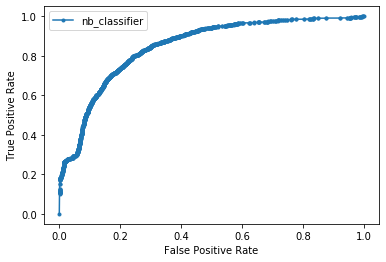

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
probs = clf_nb.predict_proba(x_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
pyplot.plot(fpr, tpr, marker='.', label='nb_classifier')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

In [74]:
clf_c_como = cm.clustered_comonotonic(x_train,y_train,discrete_feature_val,cont_col,unrankable,0.9)
clf_c_como.run_cluster()
c_como_predict = clf_c_como.cluster_predict(x_test)
utils.classwise_accuracy(y_test,c_como_predict)

{0: 0.8463642908567315, 1: 0.7525319242624394}

In [57]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, c_como_predict)

0.7975792933113355

In [56]:
from sklearn.metrics import f1_score
f1_score(y_test, c_como_predict)

0.6787221217600966

In [9]:
clf_p_como = cm.pure_comonotonic(x_train,y_train,discrete_feature_val,cont_col,unrankable)
clf_p_como.run()
p_como_predict = clf_p_como.predict(x_test)
utils.get_accuracy(p_como_predict,y_test)

0.7509360247436107

In [10]:
x_train.shape

(3, 14)

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, nb_predict))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2304
           1       0.67      0.30      0.41       768

    accuracy                           0.79      3072
   macro avg       0.73      0.62      0.64      3072
weighted avg       0.77      0.79      0.76      3072



In [25]:
print(classification_report(y_test, c_como_predict))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     23065
           1       0.00      0.00      0.00      7650

    accuracy                           0.75     30715
   macro avg       0.38      0.50      0.43     30715
weighted avg       0.56      0.75      0.64     30715



In [13]:
print(classification_report(y_test, p_como_predict))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     23065
           1       0.00      0.00      0.00      7650

    accuracy                           0.75     30715
   macro avg       0.38      0.50      0.43     30715
weighted avg       0.56      0.75      0.64     30715

